## Importing Libraries and Setting Up the Environment for ResNet Training

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import os, sys

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import necessary libraries
import time
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from utils.evaluation import set_all_seeds
from utils.plotting import plot_training_loss

## Setting Up Training Parameters for ResNet

In this section, we define several settings that will be used for training the ResNet model:

- `RANDOM_SEED`: This is the seed for the random number generator. We set it to ensure that our experiments can be reproduced.
- `BATCH_SIZE`: This is the number of training examples utilized in one iteration. We set it to 256.
- `NUM_EPOCHS`: The number of times the entire training dataset is shown to the network during training. Set to 8 in this case.
- `DEVICE`: This is the device where the tensor computations will be performed. We set it to use the first CUDA device if available, otherwise it falls back to CPU.

In [38]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 6
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
set_all_seeds(RANDOM_SEED)

In [28]:
dataPath = '../../Data/Processed_Data/'
train_val_test_split = [0.8, 0.15, 0.05]

In [29]:
class CombinedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.style_labels = []
        self.category_labels = []
        self.category_to_idx = {}
        self.style_to_idx = {}
        self.idx_to_style = []
        self.idx_to_category = []

        self._prepare_dataset()

    def _prepare_dataset(self):
        category_idx = 0
        style_idx = 0
        for category in os.listdir(self.root_dir):
            category_path = os.path.join(self.root_dir, category)
            if not os.path.isdir(category_path):
                continue
            if category not in self.category_to_idx:
                self.category_to_idx[category] = category_idx
                self.idx_to_category.append(category)
                category_idx += 1
            for style in os.listdir(category_path):
                style_path = os.path.join(category_path, style)
                if not os.path.isdir(style_path):
                    continue
                if style not in self.style_to_idx:
                    self.style_to_idx[style] = style_idx
                    self.idx_to_style.append(style)
                    style_idx += 1
                for image_name in os.listdir(style_path):
                    image_path = os.path.join(style_path, image_name)
                    if image_path.endswith(('jpg', 'jpeg', 'png')):
                        self.image_paths.append(image_path)
                        self.style_labels.append(self.style_to_idx[style])
                        self.category_labels.append(self.category_to_idx[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        style_label = self.style_labels[idx]
        category_label = self.category_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, style_label, category_label


In [30]:
##########################
### FURNITURE_DATA
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

combinedDataset = CombinedDataset(root_dir=dataPath, transform=train_transforms)

# Determine sizes for each split
total_size = len(combinedDataset)
train_size = int(train_val_test_split[0] * total_size)
valid_size = int(train_val_test_split[1] * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(combinedDataset, [train_size, valid_size, test_size])

# Apply test transform to validation and test datasets
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Checking the dataset
for image, style_label, category_label in train_loader:  
    print('Image batch dimensions:', image.shape)
    print('Image style label dimensions:', style_label.shape)
    print('Image category label dimensions:', style_label.shape)
    print('Class style labels of 10 examples:', style_label[:10])
    print('Class category labels of 10 examples:', category_label[:10])
    break

Image batch dimensions: torch.Size([128, 3, 110, 110])
Image style label dimensions: torch.Size([128])
Image category label dimensions: torch.Size([128])
Class style labels of 10 examples: tensor([ 1,  9,  6,  6,  4, 11, 13, 14, 10, 13])
Class category labels of 10 examples: tensor([5, 1, 5, 5, 3, 4, 3, 0, 3, 3])


In [31]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(torch.nn.Module):
    
    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, num_categories, num_styles):
        super(CombinedModel, self).__init__()
        # Category classification model
        self.category_model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=num_categories)
        
        # Style classification model
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size of the flattened output after the convolutional layers
        self._to_linear = None
        self.calculate_conv_output_shape()
        
        # Initialize fully connected layers with the correct input size
        self.fc1 = nn.Linear(self._to_linear + num_categories, 512)
        self.fc2 = nn.Linear(512, num_styles)

    def calculate_conv_output_shape(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 110, 110)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self._to_linear = x.numel()

    def forward(self, x):
        # Forward pass through category model
        category_logits = self.category_model(x)
        _, predicted_category = torch.max(category_logits, 1)
        
        # Forward pass through style model
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        
        # One-hot encode the predicted category
        predicted_category_one_hot = torch.zeros(x.size(0), category_logits.size(1)).to(x.device)
        predicted_category_one_hot.scatter_(1, predicted_category.unsqueeze(1), 1)
        
        # Concatenate the one-hot encoded category with image features
        x = torch.cat((x, predicted_category_one_hot), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return category_logits, x

In [33]:
# Initialize the combined model
num_categories = len(combinedDataset.category_to_idx)
num_styles = len(combinedDataset.style_to_idx)
combined_model = CombinedModel(num_categories, num_styles).to(DEVICE)

In [34]:
# Define accuracy computing for combined dataset
def compute_combined_accuracy(model, data_loader, device):
    model.eval()
    correct_category, correct_style = 0, 0
    total = 0
    with torch.no_grad():
        for features, style_labels, category_labels in data_loader:
            features = features.to(device)
            style_labels = style_labels.to(device)
            category_labels = category_labels.to(device)

            category_logits, style_logits = model(features)
            _, predicted_category = torch.max(category_logits, 1)
            _, predicted_style = torch.max(style_logits, 1)

            total += style_labels.size(0)
            correct_category += (predicted_category == category_labels).sum().item()
            correct_style += (predicted_style == style_labels).sum().item()

    accuracy_category = 100 * correct_category / total
    accuracy_style = 100 * correct_style / total
    return accuracy_category, accuracy_style


In [39]:
# Define train_model for combined datasets
def combined_train_model(model, num_epochs, train_loader, valid_loader, test_loader, optimizer, device, logging_interval=50, scheduler=None, scheduler_on='valid_acc', max_norm=1.0):
    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, style_labels, category_labels) in enumerate(train_loader):
            features = features.to(device)
            style_labels = style_labels.to(device)
            category_labels = category_labels.to(device)

            # Forward and back prop
            category_logits, style_logits = model(features)
            category_loss = torch.nn.functional.cross_entropy(category_logits, category_labels)
            style_loss = torch.nn.functional.cross_entropy(style_logits, style_labels)
            loss = category_loss + style_loss
            
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            # Logging
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc_category, train_acc_style = compute_combined_accuracy(model, train_loader, device=device)
            valid_acc_category, valid_acc_style = compute_combined_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Train Category: {train_acc_category:.2f}% | Train Style: {train_acc_style:.2f}% | Validation Category: {valid_acc_category:.2f}% | Validation Style: {valid_acc_style:.2f}%')
            train_acc_list.append((train_acc_category, train_acc_style))
            valid_acc_list.append((valid_acc_category, valid_acc_style))

        elapsed = (time.time() - start_time) / 60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:
            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1][0])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc_category, test_acc_style = compute_combined_accuracy(model, test_loader, device=device)
    print(f'Test Category Accuracy: {test_acc_category:.2f}% | Test Style Accuracy: {test_acc_style:.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


In [36]:
# Define plot accuracy for combined dataset
def combined_plot_accuracy(train_acc_list, valid_acc_list, results_dir):
    num_epochs = len(train_acc_list)

    train_acc_category, train_acc_style = zip(*train_acc_list)
    valid_acc_category, valid_acc_style = zip(*valid_acc_list)

    plt.plot(np.arange(1, num_epochs + 1), train_acc_category, label='Training Category')
    plt.plot(np.arange(1, num_epochs + 1), train_acc_style, label='Training Style')
    plt.plot(np.arange(1, num_epochs + 1), valid_acc_category, label='Validation Category')
    plt.plot(np.arange(1, num_epochs + 1), valid_acc_style, label='Validation Style')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


Initializing Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Initializing Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializing Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Initializing Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Initializi

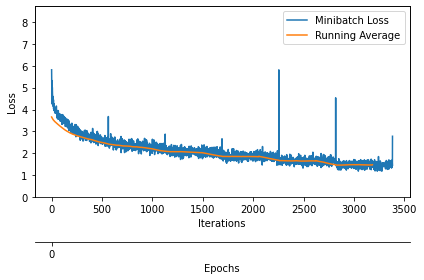

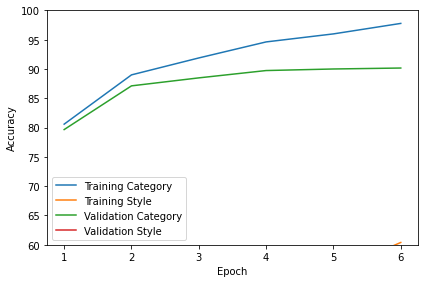

In [40]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        print(f'Initializing {m}')
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

combined_model.apply(initialize_weights)

optimizer = torch.optim.SGD(combined_model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = combined_train_model(
    model=combined_model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100
)

plot_training_loss(minibatch_loss_list=minibatch_loss_list, num_epochs=NUM_EPOCHS, iter_per_epoch=len(train_loader), results_dir=None, averaging_iterations=200)
plt.show()

combined_plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=valid_acc_list, results_dir=None)
plt.ylim([60, 100])
plt.show()


## Save the Model

In [41]:
# Save the model and optimizer state
torch.save(combined_model.state_dict(), 'ResNetStyle.pth')
torch.save(optimizer.state_dict(), 'Optimizer_(ResNetStyle).pth')

print("Model and optimizer state saved.")

Model and optimizer state saved.


In [42]:
import pickle

# Save the transformation pipeline
with open('Test_Transform.pkl', 'wb') as f:
    pickle.dump(test_transforms, f)

with open('Train_Transform.pkl', 'wb') as f:
    pickle.dump(train_transforms, f)

print("Transformation pipeline saved.")

Transformation pipeline saved.
